<a href="https://colab.research.google.com/github/madhurima1107/my-first-task/blob/main/GRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns available in the annotation sheet:
['ID', 'Gene Symbol']
Patients: ['Sheet1']
Built GRN for each patient with Gene Symbols as node labels.
Common genes: ['C12orf43', 'C6orf141', 'FKSG29', 'FREM2', 'GOLGA6A /// GOLGA6B /// GOLGA6C /// GOLGA6D', 'OK/SW-CL.36', 'OR51A7', 'PSG1 /// PSG8', 'TMEM14E', 'ZP3']


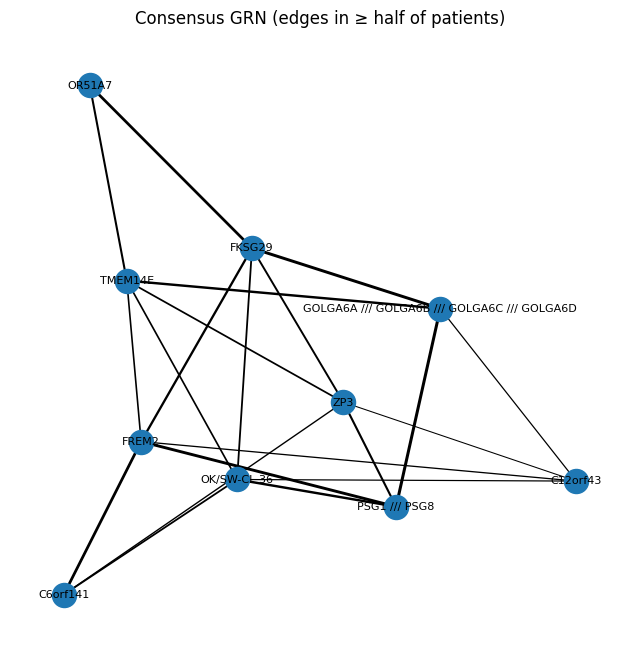

In [3]:
# 1) Install & import
!pip install xlrd pandas numpy scipy scikit-learn statsmodels networkx matplotlib tqdm

import re
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 2) Load annotation and build probe→GeneSymbol map
annot_xls = pd.ExcelFile('/content/GSE118657_Family.xlsx')
# adjust sheet_name or column names as needed

# First, read the sheet to inspect column names
# Adjust the sheet_name if necessary
temp_df = pd.read_excel(annot_xls, sheet_name=0)
print("Columns available in the annotation sheet:")
print(temp_df.columns.tolist())

# Based on the output above, adjust the column names in the 'usecols' list
# For example, if 'probe_id' is actually named 'Probe ID' in the file, change the line below
# to usecols=['Probe ID','Gene Symbol']
# Corrected column name from 'probe_id' to 'ID' based on temp_df inspection
annot_df = pd.read_excel(annot_xls, sheet_name=0, usecols=['ID','Gene Symbol'])
annot_df = annot_df.dropna(subset=['Gene Symbol'])
# Corrected the index column name to 'ID' as per the change in usecols
probe2gene = annot_df.set_index('ID')['Gene Symbol'].to_dict()

# 3) Read expression data file and list patient‐sheets
expr_xls = pd.ExcelFile('/content/GSE118657.xlsx')
patients = expr_xls.sheet_names
print("Patients:", patients)

# 4) Helper functions (as before)...
def normalize_df(df):
    df_log = np.log2(df + 1)
    return df_log.sub(df_log.mean(axis=1), axis=0).div(df_log.std(axis=1), axis=0)

def find_top_genes(df, time_points, top_k=10):
    X = sm.add_constant(time_points)
    res = []
    for gene in df.index:
        y = df.loc[gene].values
        m = sm.OLS(y, X).fit()
        res.append((gene, m.pvalues[1], m.params[1]))
    dfres = pd.DataFrame(res, columns=['gene','pval','slope'])
    return dfres.sort_values('pval').head(top_k)['gene'].tolist()

def kernel_mi(x, y, bw=0.5):
    xy = np.vstack([x,y]).T
    kde_xy = KernelDensity(bandwidth=bw).fit(xy)
    logp_xy = kde_xy.score_samples(xy)
    logp_x  = KernelDensity(bandwidth=bw).fit(x[:,None]).score_samples(x[:,None])
    logp_y  = KernelDensity(bandwidth=bw).fit(y[:,None]).score_samples(y[:,None])
    return np.mean(logp_xy - logp_x - logp_y)

def infer_aracne(data, bw=0.5, n_perm=3):
    T,G = data.shape
    M = np.zeros((G,G))
    for i in range(G):
        for j in range(i+1,G):
            m = kernel_mi(data[:,i], data[:,j], bw)
            M[i,j]=M[j,i]=m
    # threshold via permutations
    maxs = []
    for _ in range(n_perm):
        sh = data.copy()
        for g in range(G): np.random.shuffle(sh[:,g])
        vals = [kernel_mi(sh[:,i],sh[:,j],bw)
                for i in range(G) for j in range(i+1,G)]
        maxs.append(max(vals))
    I0 = np.mean(maxs)
    M[M < I0] = 0
    # DPI pruning
    for i in range(G):
        for j in range(G):
            if M[i,j] <= 0: continue
            for k in range(G):
                if k in (i,j) or M[i,k]<=0 or M[j,k]<=0: continue
                trio = [(i,j,M[i,j]), (i,k,M[i,k]), (j,k,M[j,k])]
                a,b,_ = min(trio, key=lambda x: x[2])
                M[a,b] = M[b,a] = 0
    return M

# 5) Build per‐patient networks
per_patient_adj = {}
per_patient_genes = {}

for pid in patients:
    # a) load & orient
    raw = pd.read_excel(expr_xls, sheet_name=pid, header=0, index_col=0)
    if raw.shape[0] < raw.shape[1]:
        raw = raw.T

    # b) map probe IDs → Gene Symbols
    raw.index = raw.index.map(probe2gene)
    raw = raw.dropna(axis=0)             # drop probes without a symbol
    raw = raw.groupby(raw.index).mean()   # collapse duplicates by mean

    # c) normalize
    dfn = normalize_df(raw)

    # d) extract numeric time points
    tps = [int(re.search(r'\d+', c).group()) for c in dfn.columns]

    # e) select top-10 genes
    tops = find_top_genes(dfn, tps, top_k=10)
    per_patient_genes[pid] = tops

    # f) infer network on (T × 10) data
    data10 = dfn.loc[tops].T.values
    per_patient_adj[pid] = infer_aracne(data10, bw=0.5, n_perm=3)

print("Built GRN for each patient with Gene Symbols as node labels.")

# 6) Consensus GRN
# a) find intersection of top‐lists
common = set(per_patient_genes[patients[0]])
for pid in patients[1:]:
    common &= set(per_patient_genes[pid])
common = sorted(common)
print("Common genes:", common)

# b) re‐index each adjacency to [common × common]
mats = []
for pid in patients:
    tops = per_patient_genes[pid]
    idx = [tops.index(g) for g in common]
    M = per_patient_adj[pid]
    mats.append(M[np.ix_(idx,idx)])

# c) average & threshold
sumM   = np.sum(mats, axis=0)
countM = np.sum([M>0 for M in mats], axis=0)
avgM   = sumM / len(patients)
Mmin   = max(1, len(patients)//2)
consensus = np.where(countM >= Mmin, avgM, 0)

# 7) Plot consensus network (gene symbols as node names)
Gc = nx.Graph()
Gc.add_nodes_from(common)
for i, g1 in enumerate(common):
    for j, g2 in enumerate(common):
        if j <= i: continue
        w = consensus[i,j]
        if w > 0:
            Gc.add_edge(g1, g2, weight=w)

plt.figure(figsize=(8,8))
pos = nx.spring_layout(Gc, k=0.5, seed=0)
nx.draw_networkx_nodes(Gc, pos, node_size=300)
nx.draw_networkx_edges(
    Gc, pos,
    width=[d['weight']*5 for _,_,d in Gc.edges(data=True)]
)
nx.draw_networkx_labels(Gc, pos, font_size=8)
plt.title("Consensus GRN (edges in ≥ half of patients)")
plt.axis('off')
plt.show()


In [6]:
#@title ── 2. Compute Network Metrics & Plot Analyses

# a) Basic metrics
num_nodes = Gc.number_of_nodes()
num_edges = Gc.number_of_edges()
density   = nx.density(Gc)
avg_clust = nx.average_clustering(Gc)
print(f"# Nodes: {num_nodes}")
print(f"# Edges: {num_edges}")
print(f"Density: {density:.4f}")
print(f"Avg. clustering coefficient: {avg_clust:.4f}")

# b) Degree per node
degrees = dict(Gc.degree())
# c) Betweenness centrality
btw = nx.betweenness_centrality(Gc)
# d) Closeness centrality
clo = nx.closeness_centrality(Gc)

# Summarize top-5 nodes by each centrality
import pandas as pd
metrics_df = pd.DataFrame({
    'degree': degrees,
    'betweenness': btw,
    'closeness': clo
})
print("\nTop 5 nodes by degree:")
print(metrics_df['degree'].sort_values(ascending=False).head(5))
print("\nTop 5 nodes by betweenness:")
print(metrics_df['betweenness'].sort_values(ascending=False).head(5))
print("\nTop 5 nodes by closeness:")
print(metrics_df['closeness'].sort_values(ascending=False).head(5))


# Nodes: 10
# Edges: 21
Density: 0.4667
Avg. clustering coefficient: 0.0000

Top 5 nodes by degree:
FREM2          5
FKSG29         5
TMEM14E        5
ZP3            5
OK/SW-CL.36    5
Name: degree, dtype: int64

Top 5 nodes by betweenness:
TMEM14E        0.141667
FKSG29         0.141667
ZP3            0.109722
FREM2          0.109722
OK/SW-CL.36    0.109722
Name: betweenness, dtype: float64

Top 5 nodes by closeness:
FREM2          0.692308
FKSG29         0.692308
TMEM14E        0.692308
ZP3            0.692308
OK/SW-CL.36    0.692308
Name: closeness, dtype: float64


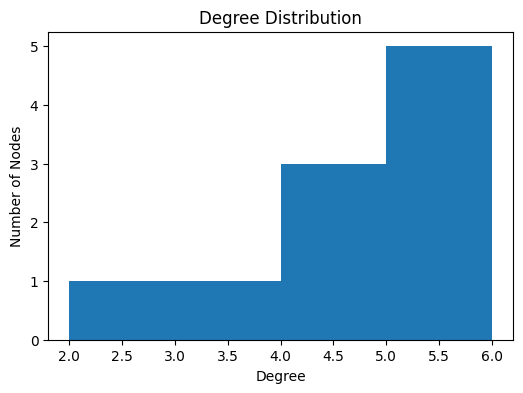

In [7]:
#@title ── 3. Plot Degree Distribution Histogram
deg_values = list(degrees.values())
plt.figure(figsize=(6,4))
plt.hist(deg_values, bins=range(min(deg_values), max(deg_values)+2))
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution')
plt.show()


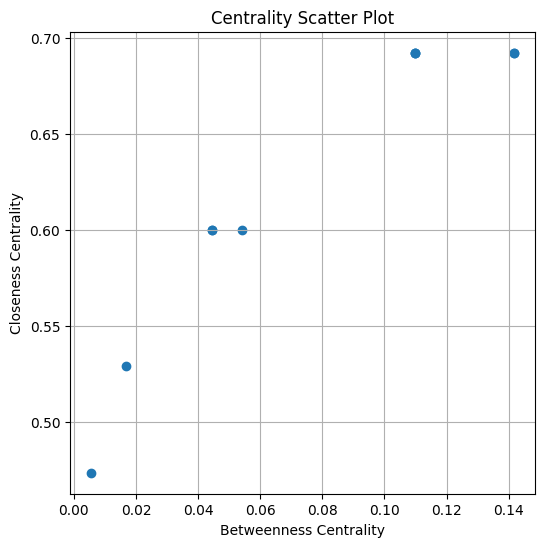

In [8]:
#@title ── 4. Plot Betweenness vs. Closeness Scatter
x = [btw[n] for n in Gc.nodes()]
y = [clo[n] for n in Gc.nodes()]

plt.figure(figsize=(6,6))
plt.scatter(x, y)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Closeness Centrality')
plt.title('Centrality Scatter Plot')
plt.grid(True)
plt.show()


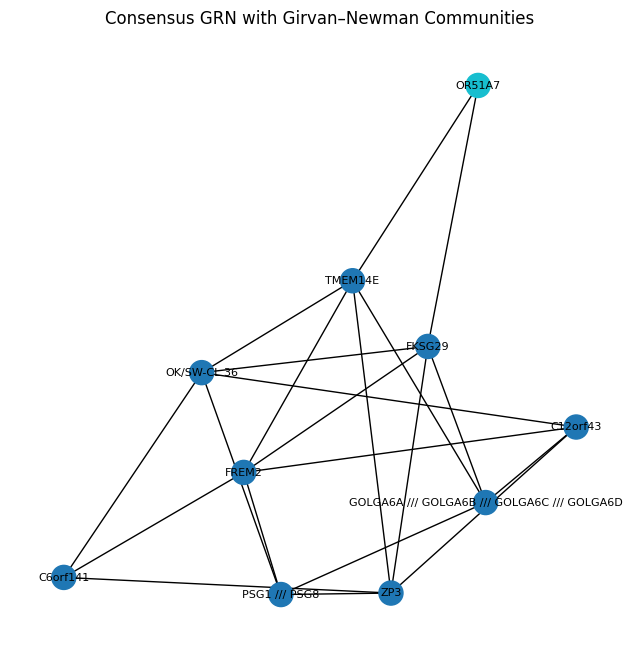

In [9]:
#@title ── 5. Visualize Community Structure via Girvan–Newman

from networkx.algorithms.community import girvan_newman

# get first two communities split
comp = girvan_newman(Gc)
communities = tuple(sorted(c) for c in next(comp))

# assign colors by community
color_map = {}
for idx, comm in enumerate(communities):
    for node in comm:
        color_map[node] = idx

node_colors = [color_map[n] for n in Gc.nodes()]

plt.figure(figsize=(8,8))
pos = nx.spring_layout(Gc, k=0.5, seed=1)
nx.draw_networkx_nodes(Gc, pos, node_size=300, cmap=plt.cm.tab10, node_color=node_colors)
nx.draw_networkx_edges(Gc, pos)
nx.draw_networkx_labels(Gc, pos, font_size=8)
plt.title('Consensus GRN with Girvan–Newman Communities')
plt.axis('off')
plt.show()
